In [1]:

import sys
import pandas as pd
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time
import calendar
#
from fpdf import FPDF
import matplotlib.pyplot as plt
import seaborn as sns

import calendar
import smtplib
from email.message import EmailMessage
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
#
#

plt.rcParams.update({'font.size': 12})

In [88]:

def conv_to_consumption(df, interval,Amin,Bmin,Cmin):
    #     convert cumulative energy to consumed energy
    
    energies = ['Consumed energy (kWh) A','Consumed energy (kWh) B','Consumed energy (kWh) C','Estimated consumed energy (kWh) A','Estimated consumed energy (kWh) B','Estimated consumed energy (kWh) C']
    mins = [Amin,Bmin,Cmin]
    
    for nrg in energies:
        
        if nrg in df.columns:
            #df['diff'] = np.nan
            if nrg=='Consumed energy (kWh) A':
                firstdif = df[nrg].iloc[0]-Amin
            elif nrg=='Consumed energy (kWh) B':
                firstdif = df[nrg].iloc[0]-Bmin
            elif nrg=='Consumed energy (kWh) C':
                firstdif = df[nrg].iloc[0]-Cmin
            else:
                firstdif = 0
            #df.loc[df[nrg]>1000000000,nrg] = np.nan
            tmp = df[[nrg]].copy()
            tmp = tmp.dropna()
            tmp['diff'] = np.nan
            tmp['diff'] = tmp[nrg] - tmp[nrg].shift()
            tmp = tmp[['diff']]
            df = pd.concat([df,tmp],axis=1)

            #df.loc[((df[nrg].isna() == False) & (df[nrg].shift().isna() == False)),'diff'] = df[nrg] - df[nrg].shift()
            
            df.loc[df['diff']>100000000,['diff',nrg]] = np.nan
            df.loc[df['diff']<0, 'diff'] = df.loc[df['diff']<0, 'diff'].values+df.loc[df['diff'].shift(-1)<0,nrg].values
            df.loc[np.abs(df['diff'])>100000000,['diff',nrg]] = np.nan
			
            #print(df.loc[np.abs(df['diff'])>100000000,['diff',nrg]])
            df['diff'].iloc[0] = firstdif
            
            df.drop([nrg], axis=1, inplace=True)
            df.rename(columns={"diff": nrg}, inplace = True)
    
     
            #df.drop([nrg], axis=1, inplace=True)
        
    
    
    if (('Consumed energy (kWh) A' in df.columns) and ('Consumed energy (kWh) B' in df.columns) and ('Consumed energy (kWh) C' in df.columns)):
        
        df['total'] = np.nan
        # df.loc[((df['Consumed energy (kWh) A'].isna() == False) | (df['Consumed energy (kWh) B'].isna() == False) | (
                # df['Consumed energy (kWh) C'].isna() == False)),'total'] = df['Consumed energy (kWh) A'] + df['Consumed energy (kWh) B'] + df['Consumed energy (kWh) C']
        #df.total = df['Consumed energy (kWh) A'] + df['Consumed energy (kWh) B'] + df['Consumed energy (kWh) C']
        df['total'] = df[['Consumed energy (kWh) A','Consumed energy (kWh) B','Consumed energy (kWh) C']].sum(axis=1)
        df.rename(columns={"total": "Total Consumed energy (kWh)"}, inplace = True)
        

    if (('Estimated consumed energy (kWh) A' in df.columns) and ('Estimated consumed energy (kWh) B' in df.columns) and ('Estimated consumed energy (kWh) C' in df.columns)):
        df['total'] = np.nan
        df.total[(df['Estimated consumed energy (kWh) A'].isna() == False) & (df['Estimated consumed energy (kWh) B'].isna() == False) & (
                df['Estimated consumed energy (kWh) C'].isna() == False)] = df['Estimated consumed energy (kWh) A'] + df['Estimated consumed energy (kWh) B'] + df['Estimated consumed energy (kWh) C']
        df.rename(columns={"total": "Total Estimated Consumed energy (kWh)"}, inplace = True)

    return df

def align_resample(df, interval,tmzn):
   
    # identify report interval and round to closest minute
    tmpdf = pd.DataFrame(df[df.columns[0]].dropna())
    tmpdf['minutes'] = tmpdf.index.minute
    
    tmpdf['interv'] = tmpdf['minutes'].shift(-1) - tmpdf['minutes']
    inter = int(tmpdf['interv'].value_counts().idxmax())
    if inter<1:inter = 1
    del tmpdf
    
    #df.index = df.index.round('5T')
    #df = df.resample(str(inter) + 'T').max()
    
    #############################
    #if 'Consumed energy (kWh) A' in df.columns:
     #   df = fill_dropped_nrg(df, ['Consumed energy (kWh) A', 'Consumed energy (kWh) B', 'Consumed energy (kWh) C'],inter)	
 ###########################
    
    if ('Consumed energy (kWh) A' in df.columns): 
        # print(df.loc[(df['Consumed energy (kWh) A'] - df['Consumed energy (kWh) A'].shift())>100000,'Consumed energy (kWh) A'])
        # df.loc[(df['Consumed energy (kWh) A'] - df['Consumed energy (kWh) A'].shift())>100000,'Consumed energy (kWh) A'] = np.nan
        
        tmp = df[['Consumed energy (kWh) A']].copy()
        tmp.dropna(inplace=True)
        
        Amin = tmp['Consumed energy (kWh) A'].min()
        if tmp.index[tmp['Consumed energy (kWh) A']==Amin][0]>tmp.index[0]:
            Amin = tmp['Consumed energy (kWh) A'].iloc[0]
        del tmp
    else:
        Amin = np.nan
    if ('Consumed energy (kWh) B' in df.columns):
        tmp = df[['Consumed energy (kWh) B']].copy()
        tmp.dropna(inplace=True)
        # print(df.loc[(df['Consumed energy (kWh) B'] - df['Consumed energy (kWh) B'].shift())>100000,'Consumed energy (kWh) B'])	
        # df.loc[(df['Consumed energy (kWh) B'] - df['Consumed energy (kWh) B'].shift())>100000,'Consumed energy (kWh) B'] = np.nan
        Bmin = tmp['Consumed energy (kWh) B'].min()
        if tmp.index[tmp['Consumed energy (kWh) B']==Bmin][0]>tmp.index[0]:
            Bmin = tmp['Consumed energy (kWh) B'].iloc[0]
        del tmp
    else:
        Bmin = np.nan
    if ('Consumed energy (kWh) C' in df.columns):
        tmp = df[['Consumed energy (kWh) C']].copy()
        tmp.dropna(inplace=True)
        # print(df.loc[(df['Consumed energy (kWh) C'] - df['Consumed energy (kWh) C'].shift())>100000,'Consumed energy (kWh) C'])
        # df.loc[(df['Consumed energy (kWh) C'] - df['Consumed energy (kWh) C'].shift())>100000,'Consumed energy (kWh) C'] = np.nan
        Cmin = tmp['Consumed energy (kWh) C'].min()
        if tmp.index[tmp['Consumed energy (kWh) C']==Cmin][0]>tmp.index[0]:
            Cmin = tmp['Consumed energy (kWh) C'].iloc[0]
        del tmp
    else:
        Cmin = np.nan
    
        
  
      
    #df.index = df.index.map(lambda x: x.replace(second=0, microsecond=0))
    df = df.groupby(df.index).max()
    df.sort_index(inplace=True)
    
    ##########set timezone
    df['ts'] = df.index
    df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn)
    df.reset_index(drop=True, inplace=True)
    df.set_index('ts',inplace = True, drop = True)
    
    
    if int(interval)>=1440:
        res = 'D'
        side = 'left'
    else:
        res = interval+'T'
        side = 'left' 
    
    
    # resample df to given interval 
    if (('Consumed energy (kWh) A' in df.columns) or ('Consumed energy (kWh) B' in df.columns) or ('Consumed energy (kWh) C' in df.columns)):
          df = conv_to_consumption(df, interval,Amin,Bmin,Cmin)
          df_nrg = df.resample(res,label = side,closed = side).sum().copy()
		  
          if (('Consumed energy (kWh) A' in df.columns) and ('Consumed energy (kWh) B' in df.columns) and ('Consumed energy (kWh) C' in df.columns)):
            df_nrg = df_nrg[['Consumed energy (kWh) A','Consumed energy (kWh) B','Consumed energy (kWh) C','Total Consumed energy (kWh)']]
          else:
            df_nrg = df_nrg[['Consumed energy (kWh) A']]
			
             
    if (('Average active power A (kW)' in df.columns) and ('Average active power C (kW)' in df.columns) and ('Average active power B (kW)' in df.columns)):
      df_demand = df.resample(res,label = side, closed = side).max().copy()
      df_demand = df_demand[['Average active power A (kW)','Average active power B (kW)','Average active power C (kW)']]
      df_demand.rename(columns={"Average active power A (kW)": "Maximum active power A (kW)","Average active power B (kW)": "Maximum active power B (kW)","Average active power C (kW)": "Maximum active power C (kW)"}, inplace = True)
      
      df = df.resample(res,label = side, closed = side).mean()
      df.reset_index(inplace = True, drop = False)
      df.set_index('ts',inplace = True, drop = False)
      df = pd.concat([df,df_demand], axis = 1)
    else:
      df = df.resample(res,label = side, closed = side).mean()
      df.reset_index(inplace = True, drop = False)
      df.set_index('ts',inplace = True, drop = False)
    if (('Consumed energy (kWh) A' in df.columns) and ('Consumed energy (kWh) B' in df.columns) and ('Consumed energy (kWh) C' in df.columns)):
      df = df.drop(['Consumed energy (kWh) A','Consumed energy (kWh) B','Consumed energy (kWh) C','Total Consumed energy (kWh)'],axis = 1)
      df = pd.concat([df,df_nrg], axis = 1)
    elif ('Consumed energy (kWh) A' in df.columns):
      df = df.drop(['Consumed energy (kWh) A'],axis = 1)
      df = pd.concat([df,df_nrg], axis = 1)
    df = df.iloc[1:]
    
    return df,Amin,Bmin,Cmin,side

def read_data(devid, acc_token, address, start_time, end_time, interval, descriptors, tmzn):
    
    # request all descriptors that have ever been assigned to this device
    req = requests.get(url = address+"/api/plugins/telemetry/DEVICE/"+devid+"/keys/timeseries",headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token})

    r1 = requests.get(url = address+"/api/plugins/telemetry/DEVICE/"+devid+"/keys/timeseries",headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    # keep estimated descriptors in dictionary and add them to list of asked descriptors
    estimated = {}
    estimated['pwrA'] = 'pwrAest'
    estimated['pwrB'] = 'pwrBest'
    estimated['pwrC'] = 'pwrCest'
    estimated['cnrgA'] = 'cnrgAest'
    estimated['cnrgB'] = 'cnrgBest'
    estimated['cnrgC'] = 'cnrgCest'
    
    
    descriptors = descriptors.split(",")
    descriptors = [x for x in descriptors if x in r1]
    
    for est in estimated.keys():
        if est in descriptors:descriptors.append(estimated[est])
        
    descriptors = ','.join(descriptors)
    
    # mapping is a dictionary to map all occurencies of descriptors to descent column names
    mapping = {}
    mapping['pwrA'] = 'Average active power A (kW)'
    mapping['pwrB'] = 'Average active power B (kW)'
    mapping['pwrC'] = 'Average active power C (kW)'
    mapping['pwrAest'] = 'Average estimated active power A (kW)'
    mapping['pwrBest'] = 'Average estimated active power B (kW)'
    mapping['pwrCest'] = 'Average estimated active power C (kW)'
    mapping['rpwrA'] = 'Reactive Power A (kVAR)'
    mapping['rpwrB'] = 'Reactive Power B (kVAR)'
    mapping['rpwrC'] = 'Reactive Power C (kVAR)'
    mapping['cnrgA'] =  'Consumed energy (kWh) A'
    mapping['cnrgB'] =  'Consumed energy (kWh) B'
    mapping['cnrgC'] =  'Consumed energy (kWh) C'
    mapping['cnrgAest'] =  'Estimated consumed energy (kWh) A'
    mapping['cnrgBest'] =  'Estimated consumed energy (kWh) B'
    mapping['cnrgCest'] =  'Estimated consumed energy (kWh) C'
    mapping['nrg'] = 'Total Consumed Energy (kWh)'
    mapping['vltA'] = 'Voltage A'
    mapping['vltB'] = 'Voltage B'
    mapping['vltC'] = 'Voltage C'
    mapping['svltA'] = 'SVoltage A'
    mapping['svltB'] = 'SVoltage B'
    mapping['svltC'] = 'SVoltage C'
    mapping['curA'] = 'Current A'
    mapping['curB'] = 'Current B'
    mapping['curC'] = 'Current C'
    mapping['scurA'] = 'SCurrent A'
    mapping['scurB'] = 'SCurrent B'
    mapping['scurC'] = 'SCurrent C'
    mapping['ecur'] = 'eCurrent A'
    mapping['ecurB'] = 'eCurrent B'
    mapping['ecurC'] = 'eCurrent C'
    mapping['frq'] = 'Frequency'
    mapping['cosA'] = 'Power factor A'
    mapping['cosB'] = 'Power factor B'
    mapping['cosC'] = 'Power factor C'
    mapping['scosA'] = 'SPower factor A'
    mapping['scosB'] = 'SPower factor B'
    mapping['scosC'] = 'SPower factor C'
    mapping['tmp'] = 'Temperature (Celsius)'
    mapping['clhmd'] = 'Humidity \%'
    mapping['hmd'] = 'Humidity \%'
    mapping['bindc'] = 'Motion'
       
    # watt_div is dictionary with descriptors to be divided by 1000
    watt_div = ['Average active power A (kW)','Average active power B (kW)','Average active power C (kW)','Total active power (kW)','Reactive Power A (kVAR)','Reactive Power B (kVAR)','Reactive Power C (kVAR)','Average estimated active power A (kW)','Average estimated active power B (kW)','Average estimated active power C (kW)','Consumed energy (kWh) A','Consumed energy (kWh) B','Consumed energy (kWh) C','Total Consumed energy (kWh)','Estimated consumed energy (kWh) A','Estimated consumed energy (kWh) B','Estimated consumed energy (kWh) C','Total Estimated Consumed energy (kWh)','Maximum active power A (kW)','Maximum active power B (kW)','Maximum active power C (kW)']
    
    r2 = requests.get(url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys="+descriptors+"&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
   
    if ((len(r2.keys())>0) & (len(descriptors)>0)):
        df = pd.DataFrame([])
        

        # read all descriptors at once
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [mapping.get(str(desc))]
            df = pd.concat([df,df1], axis = 1)
                   

        if df.empty == False:
        
            df.reset_index(drop=False, inplace=True)
            df['ts'] = pd.to_datetime(df['ts'], unit='ms')
            # df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn).dt.tz_localize(None)
    
            # Set timestamp as index, convert all columns to float
            df = df.sort_values(by=['ts'])
            #df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn)
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts',inplace = True, drop = True)
            for col in df.columns:
                df[col] = df[col].astype('float')
            
            
            
            [df,Amin,Bmin,Cmin,side] = align_resample(df, interval,tmzn)
            # df = conv_to_consumption(df, interval,Amin,Bmin,Cmin)
            
            
            for col in watt_div:
                if col in df.columns:
                    df[col] = df[col]/1000 #divide by 1000 to convert W/Wh to kW/kWh
              
            
        
            # create additional columns with total value of three phases
            if (('Average active power A (kW)' in df.columns) and ('Average active power C (kW)' in df.columns) and ('Average active power B (kW)' in df.columns)):
                df['Total Average active power (kW)'] = df['Average active power A (kW)'] + df['Average active power B (kW)'] + df['Average active power C (kW)']
                
            if (('Average estimated active power A (kW)' in df.columns) and ('Average estimated active power C (kW)' in df.columns) and ('Average estimated active power B (kW)' in df.columns)):
                df['Total Average estimated active power (kW)'] = df['Average estimated active power A (kW)'] + df['Average estimated active power B (kW)'] + df['Average estimated active power C (kW)']
                
            if (('Reactive Power A (kVAR)' in df.columns) and ('Reactive Power C (kVAR)' in df.columns) and ('Reactive Power B (kVAR)' in df.columns)):
                df['Total Reactive Power (kVAR)'] = df['Reactive Power A (kVAR)'] + df['Reactive Power B (kVAR)'] + df['Reactive Power C (kVAR)']
                
            if (('Maximum active power A (kW)' in df.columns) and ('Maximum active power B (kW)' in df.columns) and ('Maximum active power C (kW)' in df.columns)):
                df['Total Maximum active power (kW)'] = df['Maximum active power A (kW)'] + df['Maximum active power B (kW)'] + df['Maximum active power C (kW)']
    
            # convert to given timezone and split Date and Time columns
            #df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn)
            
            df['Date'] = [d.date() for d in df['ts']]
            df['Time '+str(tmzn)] = [d.time() for d in df['ts']]
            df = df.drop('ts',axis = 1)
            
            # change order of columns
            cols = df.columns.tolist()
            cols = cols[-2:]+cols[:-2]
            df = df[cols]
            
        else:
            df = pd.DataFrame([])
            side = ' '
    else:
        df = pd.DataFrame([])
        side = ' '
        print('Empty json!')
    return df,side


def send_email(email_recipient, email_subject, email_message, attachment_location = ''):
    email_sender = 'support@meazon.com'

    msg = MIMEMultipart()
    msg['From'] = email_sender
    msg['To'] = ", ".join(email_recipient)
    msg['Subject'] = email_subject

    msg.attach(MIMEText(email_message, 'plain'))
    
    if attachment_location != '':
        filename = os.path.basename(attachment_location)
        attachment = open(attachment_location, "rb")
        part = MIMEBase('application', 'octet-stream')
        part.set_payload(attachment.read())
        encoders.encode_base64(part)
        part.add_header('Content-Disposition', "attachment; filename= %s" % filename)
        msg.attach(part)
        
    try:
        server = smtplib.SMTP('smtp-mail.outlook.com', 587)
        server.ehlo()
        server.starttls()
        server.login('support@meazon.com', 'm3az0n2!')
        text = msg.as_string()
        server.sendmail(email_sender, email_recipient, text)
        print('email sent')
        server.quit()
    except:
        print("SMPT server connection error")
    return True
    
    
    
  
def pull_occupancy(acc_token, address,start_time,end_time,assetid):
    r3 = requests.get(
        url= address + "/api/plugins/telemetry/ASSET/"+ assetid +"/values/timeseries?keys=occupancy&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    df =  pd.DataFrame(r3['occupancy'])
     
    # Transform each row to dictionary and concatenate
    dictlist = []
    for i in range(0,df.shape[0]):
        globals()['d%s' % i] = dict(x.split(":") for x in df['value'].iloc[i].split(","))
        dictlist.append(globals()['d%s' % i])
    
    d = {}
    for k in d0.keys():
        d[k] = tuple(d[k] for d in dictlist)
    ndf = pd.DataFrame.from_dict(d)
    
    
    df = pd.concat([df,ndf],axis=1)
    df.drop('value',axis=1,inplace=True)
    
    
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')
    df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
    

    # Set timestamp as index, convert all columns to float
    df = df.sort_values(by=['ts'])
    df.reset_index(drop=True, inplace=True)
    df.set_index('ts',inplace = True, drop = True)
    for col in df.columns:
        df[col] = df[col].astype('float')
    
    df['Total'] = df.sum(axis=1) 
    df = df.iloc[:-1]
    
    
    return df
    
    
def nrg_occ(df,occ):

    df = df[['Total Consumed energy (kWh)']]
    df = df.resample('1M',label='right').sum()
    occ = occ.resample('1M',label='right').sum()
    df = pd.concat([df,occ],axis=1)
    df['Energy per room'] = df['Total Consumed energy (kWh)']/df['Total']
    
    
    fig = plt.figure(figsize=[7.5,5])
    plt.plot([calendar.month_name[month] for month in df.index.month],df['Energy per room'], color='c', marker='o')
    
    plt.title('Monthly energy per room index')
    plt.xlabel('Date')
    plt.ylabel('kWh/room')
    fig.tight_layout()
    fig.savefig('energy_room.png',dpi=150)
    #print(df)
    

    
def EnPis(dftotal, dfair, occ):
    rows = ['Total occupancy','Average daily occupancy','Total consumption per occupied room','Air Condition consumption per occupied room','Total consumption per sq.meter','Air condition consumption per sq.meter','Energy cost per occupied room']
    enpi_list = []
    
    totalOcc = occ['Total'].sum()
    totalnrg = dftotal['Total Consumed energy (kWh)'].sum()
    totalair = dfair['Total Consumed energy (kWh)'].sum()
    kwval = 0.12
    sqm = 5258.54
    
    enpi_list.append([totalOcc])
    enpi_list.append([round(totalOcc/occ.shape[0],2)])
    enpi_list.append([round(totalnrg/totalOcc,2)])
    enpi_list.append([round(totalair/totalOcc,2)])
    enpi_list.append([round(totalnrg/sqm,2)])
    enpi_list.append([round(totalair/sqm,2)])
    enpi_list.append([round(totalnrg*kwval/totalOcc,2)])
    columns = ['EnPIs']
    
    fig = plt.figure(figsize=(7.5,7.5))
    ax1 = plt.subplot(aspect='equal')
    ax1.axis('off')
    colors = plt.cm.GnBu(np.linspace(0, 0.8, len(rows)))
    t= ax1.table(cellText=enpi_list, colLabels=columns, rowLabels=rows, loc='center', cellLoc ='center', colLoc='center', rowColours=colors,colColours='c',colWidths=[0.5,0.5])
    t.auto_set_font_size(False) 
    t.set_fontsize(8)
    
#     fig.tight_layout()
    fig.savefig('EnPis.png',bbox_inches='tight',dpi=150)
    
    
    return
    
    
def daily_stats(df,label,color):
    
    dftmp = df[['Total Average active power (kW)']].copy()
    dftmp['Average active power (kW)'] = df['Total Average active power (kW)']
    dftmp['Minimum active power (kW)'] = df['Total Average active power (kW)']
    dftmp['Maximum active power (kW)'] = df['Total Average active power (kW)']
    dftmp = dftmp[['Average active power (kW)','Minimum active power (kW)','Maximum active power (kW)']]
    dftmp = dftmp.resample('1D').agg({'Average active power (kW)': 'mean', 'Minimum active power (kW)': 'min', 'Maximum active power (kW)': 'max'})
    
   
    
    fig = plt.figure(figsize=(20,8))
    ax1 = plt.subplot(aspect='equal')
    ax1.axis('off')
    #ax1.axis('tight')
    #t= axs[0].table(cellText=sum_nrg.round(decimals=2).values, colWidths = [0.5]*len(sum_nrg.columns),  colLabels=sum_nrg.columns,  loc='center')
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(dftmp.index)))
    t= ax1.table(cellText=dftmp.round(decimals=2).values, colLabels=dftmp.columns, rowLabels=dftmp.index.date, loc='center', cellLoc ='center', colLoc='center', rowColours=colors,colColours=['c','tab:orange','tab:purple'])
    t.auto_set_font_size(False) 
    #t.set_fontsize(10)
    
    fig.tight_layout()
    fig.savefig('dailyStats_'+str(label)+'.png',dpi=150)
    
    
    maxpwr = df.loc[df['Total Average active power (kW)'] == df['Total Average active power (kW)'].max(),'Total Average active power (kW)']
    minpwr =df.loc[df['Total Average active power (kW)'] == df['Total Average active power (kW)'].min(),'Total Average active power (kW)']
    stats = pd.DataFrame(pd.concat([maxpwr,minpwr]))
    stats['Statistic'] = ['Maximum','Minimum']
    stats.rename(columns={'Total Average active power (kW)':'Active power (kW)'},inplace=True)
    print('stats:',stats)
    avgpwr = df['Total Average active power (kW)'].mean()
    
    
    ax1 = plt.subplot(aspect='equal')
    ax1.axis('off')
    #ax1.axis('tight')
    #t= axs[0].table(cellText=sum_nrg.round(decimals=2).values, colWidths = [0.5]*len(sum_nrg.columns),  colLabels=sum_nrg.columns,  loc='center')
    colors = plt.cm.BuGn([0.1, 0.5])
    t= ax1.table(cellText=stats.round(decimals=2).values, colLabels=stats.columns, rowLabels=stats.index, loc='center', cellLoc ='center', colLoc='center', colWidths=[0.3 for x in stats.columns],colColours=colors)
    t.auto_set_font_size(False) 
    #t.set_fontsize(10)
    fig.tight_layout()
    fig.savefig('monthlyStats_'+str(label)+'.png',dpi=150)
    

def MaxPwr(df,label):
    dftmp = df[['Total Average active power (kW)']].copy()
    dftmp = dftmp.resample('1H').mean()

    dftmp = dftmp.sort_values(by = ['Total Average active power (kW)'],ascending=False)
    dftmp = dftmp.iloc[:10]
    dftmp.columns = ['Maximum '+str(label)+' hourly power (kW)']
    
    fig = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(aspect='equal')
    ax1.axis('off')
    colors = plt.cm.Spectral_r(np.linspace(0, 0.5, len(dftmp.index)))
    t= ax1.table(cellText=dftmp.round(decimals=2).values, colLabels=dftmp.columns, rowLabels=dftmp.index, loc='center', cellLoc ='center', colLoc='center', colWidths=[0.9 for x in dftmp.columns],rowColours=colors,colColours=['tab:purple'])
    t.auto_set_font_size(False) 
    #t.set_fontsize(10)
    
    fig.tight_layout()
    fig.savefig('10maxPwr_'+str(label)+'.png',dpi=150)
    
    
        
    
def plot_energy_for_each_day(df,label,color):

    df = df.resample('1D').sum()
    month = calendar.month_name[df.index[0].month]

    fig, ax = plt.subplots(figsize=(7.5, 5.0))
    plt.setp(ax.xaxis.get_majorticklabels())
    plt.bar(df.index.day, df['Total Consumed energy (kWh)'],color=color)
    plt.xlabel('Days of month')
    plt.ylabel('Energy [kWh]')
    plt.xticks(df.index.day,rotation=90)
    plt.title(str(label)+' consumption during ' + month)
    fig.tight_layout()
    plt.savefig('monthly_'+str(label)+'.png',dpi=150)
    return month
    
def box_plots(tmp,label):
    df = tmp.copy()
    df['day'] = df.index.to_period('D')

    fig,ax = plt.subplots()
    #df.boxplot(column=['Total Average active power (kW)'],ax=ax,by='day',rot=90,showfliers=False,figsize=(15.0, 10.0))
    #ax.xticks(df.index.day)
    #fig.tight_layout()
    #plt.savefig('boxplot_'+str(label)+'.png')
    
    df.rename(columns={'Total Average active power (kW)':'Active power (kW)'},inplace=True)
    fig.set_size_inches((12,8))
    bplot = sns.boxplot(x='day',y='Active power (kW)',data=df,ax=ax)
    ax.set_title('Boxplot of '+str(label)+' active power')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    bplot.figure.savefig('boxplot_'+str(label)+'.png',dpi=150)
    #bplot = sns.boxplot(y='Total Average active power (kW)', x='day',data=df,width=0.5, palette="colorblind")
    #bplot.set_xlabel('Days of month')
    #bplot.set_ylabel('Active power [kW]')
    #bplot.tick_params(labelsize=10)
    #bplot.set_title('Active power boxplots for ' + str(label))
    #bplot.figure.savefig('boxplot_'+str(label)+'.png')
    
    
    return 
    
    
    
def heatmap_nrg(df):
   
    df = df.resample('1H').mean()
    #df.reset_index(drop = False, inplace = True)
    df['hour'] = df.index.hour
    month = calendar.month_name[df.index[0].month]
    
    df = pd.pivot_table(df, 'Total Average active power (kW)', df.index.day, 'hour')
    fig, ax = plt.subplots(figsize=(7.5, 5.0))
    sns.heatmap(df, cmap="Blues")
    plt.title('Heatmap of active power (kW)')
    plt.xlabel('Hours')
    plt.ylabel('Days of month')
    plt.savefig('heatmap_nrg.png',dpi=150)
    
    
def plot_pie(sum_nrg):

    for i in range(0,sum_nrg.shape[0]):
        sum_nrg['Power meter'].iloc[i] = sum_nrg['Power meter'].iloc[i][7:]
        sum_nrg['Power meter'].iloc[i] = sum_nrg['Power meter'].iloc[i][:-19]
    
    nrg = pd.DataFrame(sum_nrg.append({'Power meter':'Other','Total consumed energy (kWh)':0},ignore_index=True))

    total = nrg.loc[nrg['Power meter']=='Total','Total consumed energy (kWh)'].values
    res = nrg.loc[nrg['Power meter']!='Total','Total consumed energy (kWh)'].sum()
    
    
    #other = total - nrg.iloc[:-1]['Total consumed energy (kWh)'].sum()
    other = total - res
    nrg.loc[nrg['Total consumed energy (kWh)']<1,'Total consumed energy (kWh)'] = other
    
    
    sum_nrg = sum_nrg.append({'Power meter':'Other','Total consumed energy (kWh)':0},ignore_index=True)
    sum_nrg.loc[sum_nrg['Total consumed energy (kWh)']<1,'Total consumed energy (kWh)'] = other
    # sort alphabetially and create percentage column
    sum_nrg = sum_nrg.sort_values('Power meter')
    sum_nrg['Percentage'] = np.nan
    for i in range(0,sum_nrg.shape[0]):
        sum_nrg['Percentage'].iloc[i] = str(np.round((sum_nrg['Total consumed energy (kWh)'].iloc[i]/total)[0]*100,2))+' %'
    
        
    #####################
    fig = plt.figure(figsize=(20,15))
    ax1 = plt.subplot(211, aspect='equal')
    ax1.axis('off')
    #ax1.axis('tight')
    #t= axs[0].table(cellText=sum_nrg.round(decimals=2).values, colWidths = [0.5]*len(sum_nrg.columns),  colLabels=sum_nrg.columns,  loc='center')
    t= ax1.table(cellText=sum_nrg.round(decimals=2).values, colLabels=sum_nrg.columns,  loc='center',cellLoc ='center', colLoc='center', colColours=['c','c','c'],colWidths=[0.5 for x in sum_nrg.columns])
    t.auto_set_font_size(False) 
    t.set_fontsize(14)
    
    

    #####################
    
    nrg = nrg.drop(nrg[nrg['Power meter']=='Total'].index)
    nrg.reset_index(inplace=True, drop = True)
    
    nrg.set_index('Power meter',inplace=True, drop=True)
    
    cmap = plt.get_cmap('tab20')
    inner_colors = cmap(np.array([13,3,5,7,9,19,18]))
    
    ax2 = plt.subplot(212)
    #fig = plt.figure(figsize=(13, 10))
    #plt.pie(nrg['Total consumed energy (kWh)'].values,colors=inner_colors,autopct='%1.1f%%')
    nrg.plot.pie(y = 'Total consumed energy (kWh)',ax = ax2, colors=inner_colors,autopct='%1.1f%%', radius=0.9)
    #ax2.legend(loc = 'lower right')
    fig.tight_layout()

    
    fig.savefig('moxypie.png',dpi=150)



class FPDF(FPDF):
    # Page footer
    def footer(self):
        # Position at 1.5 cm from bottom
        self.set_y(-15)
        # Arial italic 8
        self.set_font('Arial', 'I', 8)
        # Page number
        self.cell(0, 10, str(self.page_no()), 0, 0, 'C')
        #self.set_y(-10)
  #      self.image('picturemessage_vinnf3lu.tl2.png', x=180, y=None, w=25, h=8)
    def header(self):
        self.set_y(10)
        self.image('meazon.png', x=10, y=None, w=30, h=10)




        



1604181300000 1606773600000
label: Moxy - 4th Floor Energy Consumption
label: Moxy - 5th Floor Energy Consumption
label: Moxy - 1st Floor Energy Consumption
label: Moxy - Total Energy Consumption
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', '

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


stats:                            Active power (kW) Statistic
ts                                                    
2020-11-01 18:45:00+02:00          81.749881   Maximum
2020-11-29 05:35:00+02:00          21.581438   Minimum


/home/emilyp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:487: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


label: Moxy - Air Condition Energy Consumption
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or vari

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


stats:                            Active power (kW) Statistic
ts                                                    
2020-11-13 10:05:00+02:00          27.455833   Maximum
2020-11-29 13:10:00+02:00           2.302746   Minimum


/home/emilyp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:487: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


label: Moxy - 3rd Floor Energy Consumption
label: Moxy - 2nd Floor Energy Consumption
label: Moxy - Δωμάτιο Ισογείου
Empty json!
label: Moxy - Lobby
Empty json!
label: Moxy - Κουζίνα
Empty json!
label: Moxy - Roof Bar
Empty json!
label: Moxy - Μηχανοστάσιο
Empty json!
Month: November


/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/

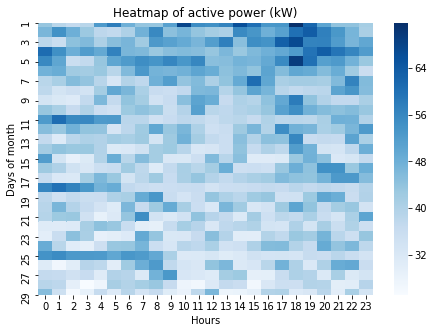

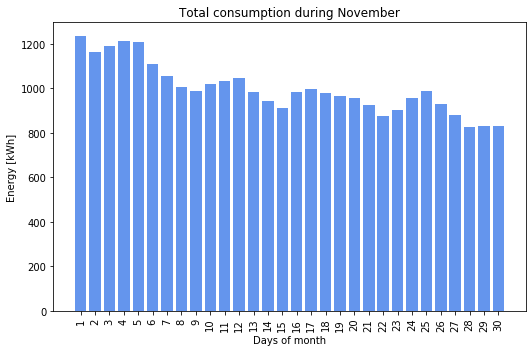

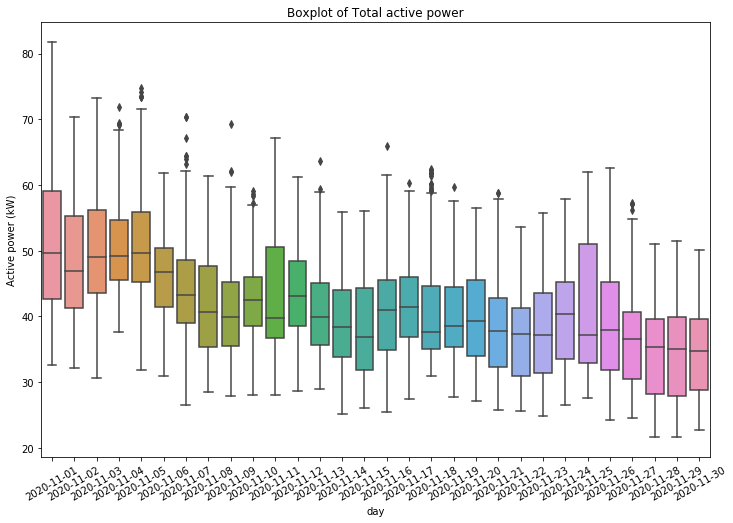

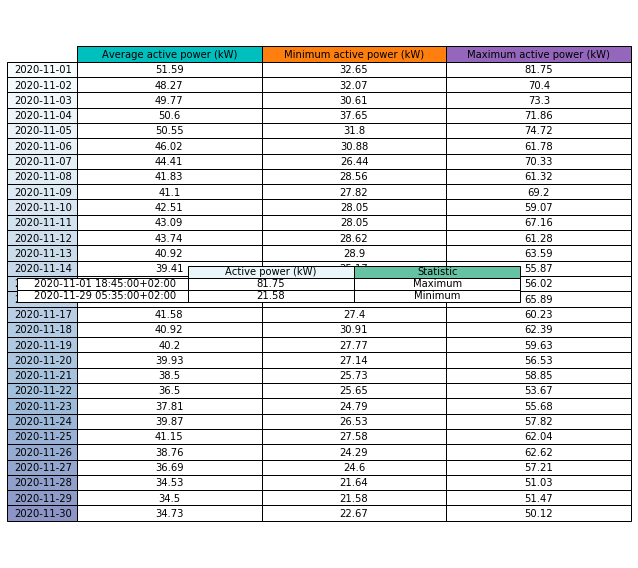

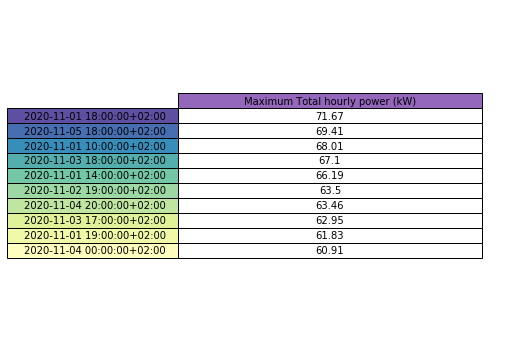

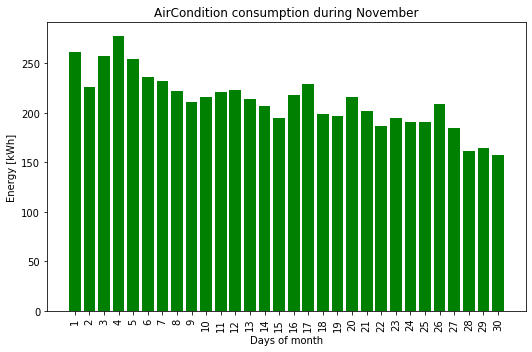

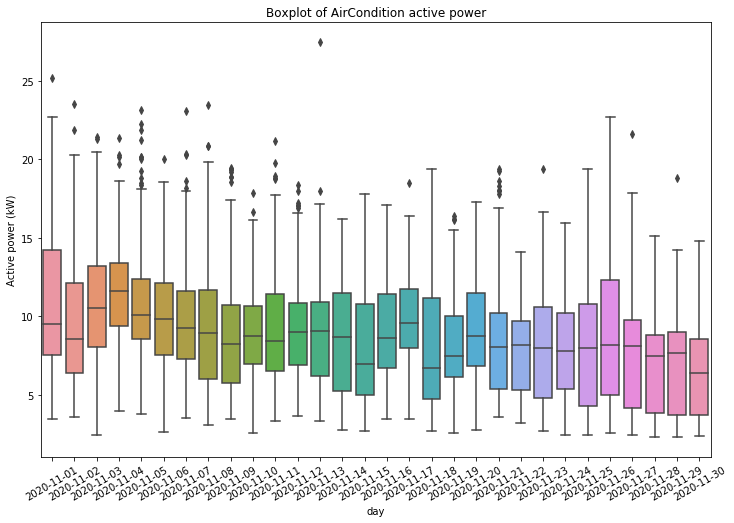

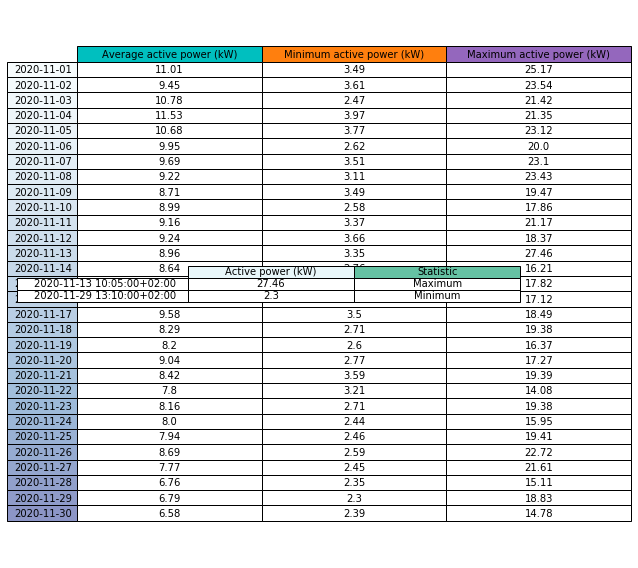

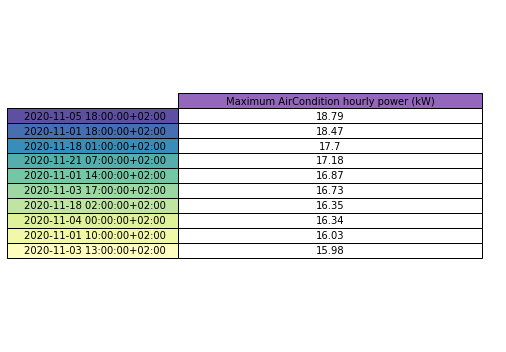

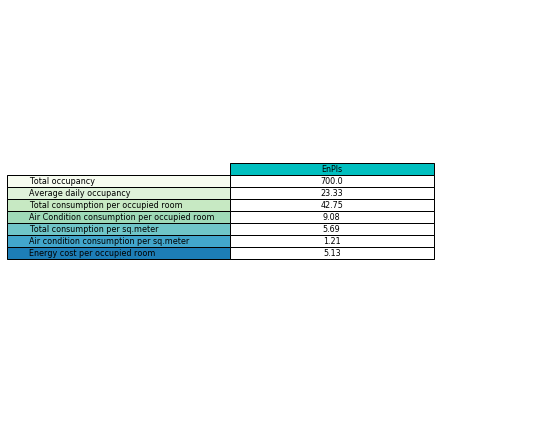

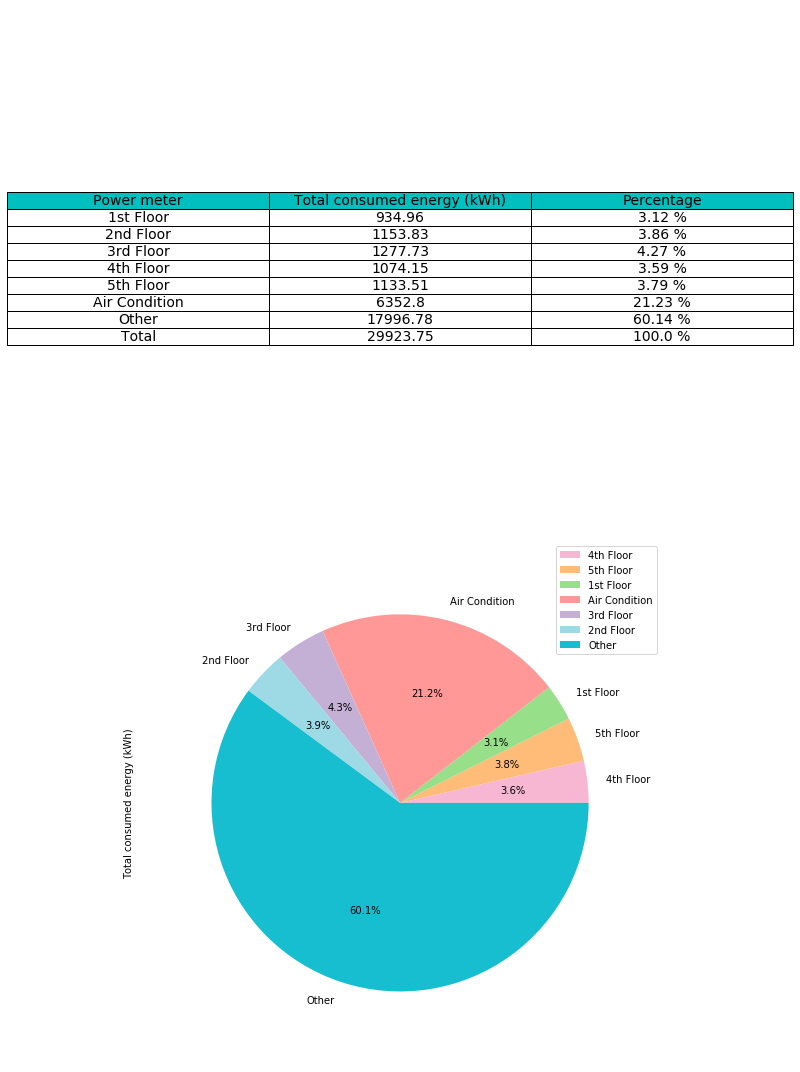

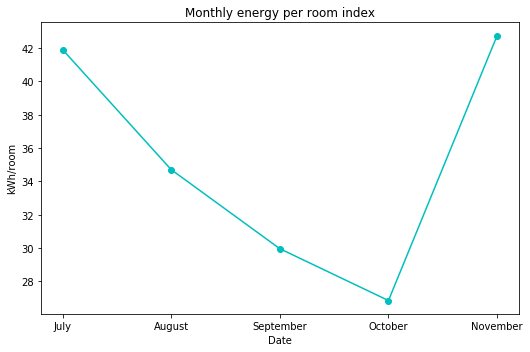

In [89]:

# input arguments
entityName = 'Moxy'
entityID = 'ed73a120-f73b-11e9-b4dc-013e65d2f65e'
asset_id = 'ed73a120-f73b-11e9-b4dc-013e65d2f65e'

interval = '5'
descriptors = 'pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC'


#######################
dt = datetime.datetime.utcnow()

# get 1st day of previous month
endm = datetime.datetime(year = dt.year, month=dt.month, day=1)
startm = datetime.datetime(year = dt.year, month=dt.month-1, day=1)

tmzn = pytz.timezone('Europe/Athens')    
endm = tmzn.localize(endm)
startm = tmzn.localize(startm)

#endm = endm - timedelta(seconds = 1) # 1

end_time = str(int((endm ).timestamp() * 1000))
start_time = str(int((startm ).timestamp() * 1000)- int(interval)*60000)
#######################
print(start_time,end_time)

path = '/home/iotsm/HttpServer_Andreas/moxyfiles/'
#os.chdir(path)
filename = entityName+'_'+start_time+'_'+end_time+'.xlsx'

#address = "http://157.230.210.37:8081"
address = "https://m3.meazon.com"


r = requests.post(address + "/api/auth/login",json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()


# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']

# Read building's meters
r1 = requests.get(url=address + '/api/relations/info?fromId=' + entityID + '&fromType=ASSET',
                  headers={'Content-Type': 'application/json', 'Accept': '*/*',
                           'X-Authorization': acc_token}).json()

# Read occupancy for each day
occ = pull_occupancy(acc_token, address,start_time,end_time,asset_id)


sum_nrg = pd.DataFrame([])
for device in r1:

    # read ID and name of building's devices
    devid  = str(device['to']['id'])
    devName = str(device['toName'])
    r3 = requests.get(url=address + '/api/device/'+devid,headers={'Content-Type': 'application/json', 'Accept': '*/*','X-Authorization': acc_token}).json()
    label = r3['label']

    print('label:',label)
    [summary,side] = read_data(devid,acc_token,address, start_time, end_time, interval, descriptors,tmzn)
    #summary = summary.iloc[:-1]
    if summary.empty==False:
        month_Name = calendar.month_name[summary.index[0].month]
        new_row = {'Power meter':label, 'Total consumed energy (kWh)':summary['Total Consumed energy (kWh)'].sum()}
        sum_nrg = sum_nrg.append(new_row, ignore_index = True)

        if label=='Moxy - Total Energy Consumption':
            dftotal = summary.copy()
            color = 'cornflowerblue'
            heatmap_nrg(summary)
            label = 'Total'
            plot_energy_for_each_day(summary,label,color)
            print(summary.head())
            box_plots(summary,label)
            daily_stats(summary,label,color)
            MaxPwr(summary,label)

        if label=='Moxy - Air Condition Energy Consumption':
            dfair = summary.copy()
            color = 'green'
            label = 'AirCondition'
            plot_energy_for_each_day(summary,label,color)
            box_plots(summary,label)
            daily_stats(summary,label,color)
            MaxPwr(summary,label)


print('Month:',month_Name)
EnPis(dftotal,dfair,occ)

plot_pie(sum_nrg)

# retrieve consumption and occupancy data from June
devid = '29b46ec0-42a1-11ea-8762-6bf954fc5af1'
start_time = str(1593550800000 - int(interval)*60000)
[df,side] = read_data(devid,acc_token,address, start_time, end_time, interval, 'cnrgA,cnrgB,cnrgC',tmzn)
occ = pull_occupancy(acc_token, address,start_time,end_time,asset_id)

# plot line chart for these months
nrg_occ(df,occ)

# Create pdf
filename='Moxy_'+str(month_Name)+'_report.pdf'




    


In [86]:
def create_pdf(path, filename, month_Name):
        
    pdf = FPDF()
    pdf.add_page()
    pdf.set_xy(20, 20)
    pdf.set_font('arial', 'B', 16)
    pdf.cell(0, 10, "Summarized activity of month: "+ month_Name, 0, 1, 'C')

    pdf.set_font('arial', '', 12)
    str9 = " "
    pdf.write(5, str9)

    pdf.set_xy(20, 35)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(0, 10, "Energy loads & pie chart", 0, 1, 'C')
    pdf.cell(40, 10, " ", 0, 2, 'C')
    pdf.image('moxypie.png', x=10, y=None, w=200, h=150, type='', link='')
     
    # page 2
    
    pdf.add_page()
    pdf.set_xy(20, 20)
    pdf.cell(0, 10, "Energy/room", 0, 1, 'C')
    pdf.cell(75, 10, " ", 0, 2, 'C')
    pdf.image('energy_room.png', x=30, y=None, w=150, h=100, type='', link='')
    
    pdf.set_xy(10, 170)
    pdf.set_font('arial', 'B', 12)
    pdf.cell(0, 10, "Energy Performance Indicators", 0, 1, 'C')
    pdf.image('EnPis.png', x=40, y=None,w=160, h=110, type='', link='')
    
#     #pdf.set_xy(10, 100)
#     pdf.image('monthlyStats_Total.png', x=40, y=None,w=150, h=110, type='', link='')
    
#     #pdf.set_xy(10, 150)
#     pdf.image('monthlyStats_AirCondition.png', x=40, y=None,w=150, h=110, type='', link='')
    
    
#     pdf.set_font('arial', 'B', 12)
#     pdf.cell(0, 10, "Monthly energy/room index\n", 0, 1, 'C')    
#     pdf.cell(75, 10, " ", 0, 2, 'C

    #page 3
#     pdf.add_page()
#     pdf.set_xy(20, 20)
#     pdf.set_font('arial', 'B', 12)
#     pdf.cell(0, 10, "Energy loads & pie chart", 0, 1, 'C')
#     pdf.cell(40, 10, " ", 0, 2, 'C')
    #
        
    pdf.output(filename + ".pdf", 'F')
    
    return
    

In [87]:

create_pdf(path, filename, month_Name)